# Poisson Disk Sampling


This module is an implementation of the active mini-batch sampling scheme proposed by [[1]](https://arxiv.org/pdf/1804.02772.pdf). Repuslive point processes are a formalism to sample a susbet of points that Zhang *et al.* show can reduce the variance of stochastic gradient estimates. Poisson disk sampling is one such repulsive point process that has a small overhead compared to similar schemes such as determinantal point processes [[2]](https://arxiv.org/abs/1705.00607).


[[1]](https://arxiv.org/abs/1804.02772) C. Zhang *et al.*, Active Mini-Batch Samplingusing Repulsive Point Processes, arXiv:1804.02772, (2018).

[[2]](https://arxiv.org/abs/1705.00607) C. Zhang *et al.*, Determinantal Point Processes for Mini-Batch Diversification, arXiv:1705.00607, (2017)

In [5]:
# import sys  
# sys.path.insert(0, 'C:\Users\Sriph\Desktop\Active-Sampling\sampling\sampling')
# import PoissonDiskSampling
import pds
from pds import PoissonDiskSampling
import matplotlib.pyplot as plt
import numpy as np
import itertools
from sklearn.metrics import accuracy_score
from pydoc import locate
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

ModuleNotFoundError: No module named 'pds'

### Toy problem

Let's imagine a toy classifier $\mathbb{R}^2\rightarrow\mathbb{Z}$ that assigns a class label $y$ by:

\begin{equation}
y = \begin{cases}
0 &, x^2 > \sin(x^1) \\
1 &, \mathrm{otherwise}
\end{cases}
\end{equation},

where $\mathbf{x}=(x^1,x^2)\in\mathbb{R}^2$.

In [16]:
true_classifier = lambda _x : 0 if _x[1]>np.sin(_x[0]) else 1

Generate a set of training examples with a bias away from the decision boundary.

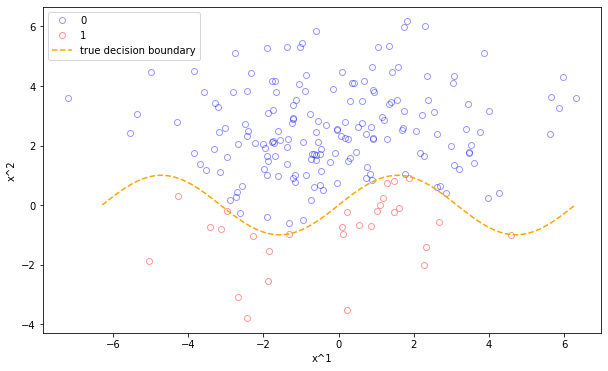

In [17]:
# generate toy data
X = np.random.multivariate_normal(mean=[0,2],cov=[[2*np.pi,0],[0,np.pi]],size=200)

# true labels
y = np.asarray([true_classifier(_x) for _x in X])

def plot_train_data(X,y,_ax):
    _ax.plot(X[np.where(y==0)[0]][:,0],X[np.where(y==0)[0]][:,1],\
             marker="o",color="blue",linestyle="none",label="0",\
             markerfacecolor="none",alpha=0.4)
    _ax.plot(X[np.where(y==1)[0]][:,0],X[np.where(y==1)[0]][:,1],\
            marker="o",markerfacecolor="none",linestyle="none",\
            color="red",label="1",alpha=0.4)

    _ax.plot(np.linspace(-np.pi*2,np.pi*2,100),\
            np.sin(np.linspace(-np.pi*2,np.pi*2,100)),color="orange",\
            linestyle="--",label="true decision boundary")
    
    _ax.set_xlabel("x^1")
    _ax.set_ylabel("x^2")
    _ax.legend()


fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(10,6))    
    
    
plot_train_data(X,y,ax)    
plt.show()

Figure 1: Categorical labelled data and the true decision boundary.

### Sampling variations

Zhang *et al.* [[1]](https://arxiv.org/abs/1804.02772) cover a number of variations in the mini-batch diversification via Poisson disk sampling.

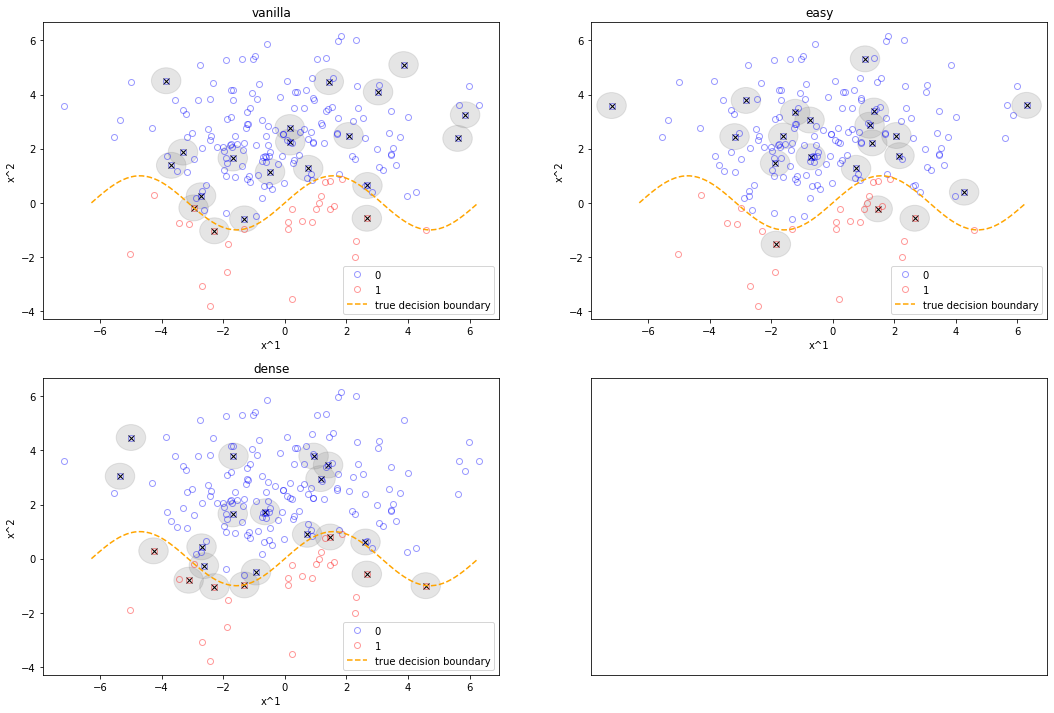

In [18]:
samplers = {_k:PoissonDiskSampling(X,y,_k) for _k in ["vanilla","easy","dense"]}
samples = {_k:samplers[_k].sample(20) for _k in samplers.keys()}
keys = list(samplers.keys())


fig,axes = plt.subplots(nrows=2,ncols=2,figsize=(18,12))

for ii,[rr,cc] in enumerate(itertools.product(range(2),range(2))):
    if ii==3:
        axes[rr][cc].set_xticks([])
        axes[rr][cc].set_yticks([])
        break
    # sampled points
    axes[rr][cc].plot(samples[keys[ii]][0][:,0],samples[keys[ii]][0][:,1],marker="x",linestyle="none",\
            color="black")

    # show complete train set
    plot_train_data(X,y,axes[rr][cc])

    # show exclusion zones
    _ = [axes[rr][cc].add_artist(plt.Circle(_x, samplers[keys[ii]].r, color='grey',alpha=0.2)) \
            for _x in samples[keys[ii]][0]]
    
    axes[rr][cc].set_title(keys[ii])

#ax.set_aspect("equal")
plt.show()

Figure 2: A single mini-batch sample of 20 points has been drawn from the complete set of categorical data using the various Poisson disk sampling (PDS) methods described by Zhang *et al.* as "vanilla", "easy" and "dense". In vanilla PDS, all points repulse equally, independent on their mingling index. Unlike vanilla PDS, the easy variant sets the repulsion for points with a mingling index greater then 0, to 0. Statsitically, easy PDS samples more difficult points (closer to the decision boundary) then vanilla PDS. Dense PDS draws new points based on arbitrary categorical distributions of the mingling index for each point. This allows for an arbitrary bias towards easy of difficult to classify points, that can be changed actively throughout the stochastic gradient descent.


Lets calculate a minimum cross-entropy estimate 

\begin{equation}
L(\mathbf{z}) = -\sum_{i} p(t_i) \ln p(y_i | \mathbf{x}_i,\mathbf{z}),
\end{equation}
where $p(t_i)$ are Dirac delta functions centred on observed labels $t_i$ and $p(y_i | \mathbf{x}_i,\mathbf{z})$ is the amortized categorical distribution resulting from a fully-connected feed-forward neural network with latent variables $\mathbf{z}$.

In [19]:
class MLPClassifier():
    def __init__(self,number_nodes=[5,5],maxiter=10,Nsample=20,initial_learning_rate=1e-3,decay_learning_rate=1e-1):
        # dimension of input
        self.dimX = 2
        
        # number of categories
        self.dimY = 2
        
        # nodes per layer
        self.number_nodes = number_nodes
        
        # non-linear function to apply to all but final output layer
        self.activation_type = "sigmoid"
        
        # number of samples in mini-batch
        self.Nsample = Nsample
        
        # learning rate for SGD
        self.lr = initial_learning_rate
        
        # pre-factor for learning rate
        self.init_learning_rate = initial_learning_rate
        
        # exponential decay factor for learning rate
        self.decay_learning_rate = decay_learning_rate
        
        # number of mini-batch iterations
        self.maxiter = maxiter
        
        # define conditional dependencies
        self._init_graph()
        
    def _init_graph(self):
        # nodes per layer including input and output
        nodes = [self.dimX]+list(self.number_nodes)+[self.dimY]
                        
        with tf.variable_scope("observed_variables"):
            # unknown mini-batch size
            self.X = tf.placeholder(tf.float64,[None,self.dimX],name="X")
            self.T = tf.placeholder(tf.float64,[None,self.dimY],name="T")
        
        with tf.variable_scope("latent_variables"):
            # list of weights for each successive layer in MLP
            self.weights = [tf.Variable(tf.random.normal(shape=(nodes[ii],nodes[ii+1]),dtype=tf.float64),\
                    name="w{}".format(ii)) for ii in range(len(self.number_nodes)+1)]

            # biases
            self.biases = [tf.Variable(tf.zeros(shape=(nodes[ii+1]),dtype=tf.float64),name="b{}".format(ii)) \
                    for ii in range(len(self.number_nodes)+1)]
         
        # [None,self.dimY] array of category probabilities
        self._construct_model()

        # objective to minimize stochastically wrt latent parameters in net
        self._construct_loss()
        
        # start tf session
        self.session = tf.Session()
        
        # create instances of variables
        self.session.run(tf.global_variables_initializer())
        
                
    def _construct_model(self):
        # activation function for intermediate layers
        act1 = {"sigmoid":tf.math.sigmoid,"tanh":tf.math.tanh}[self.activation_type]
        
        # final layer
        idx = len(self.weights)-1
        
        # non-linear operation on output layer ii
        act_func = lambda _x,ii : act1(_x) if ii!=idx else tf.math.softmax(_x)
        
        
        layer_output = act_func(tf.add(tf.matmul(self.X,self.weights[0]),self.biases[0]),0)
        for ii in range(1,len(self.weights)):
            layer_output = act_func(tf.add(tf.matmul(layer_output,self.weights[ii]),self.biases[ii]),ii)   
        self.y = layer_output
     
        
    def _construct_loss(self):
        # use cross entropy
        self._loss = tf.reduce_mean(-tf.reduce_sum(self.T * tf.log(self.y), reduction_indices=[1]))
   
        # SGD optimizer
        self.optimizer = tf.train.GradientDescentOptimizer(learning_rate=self.lr)
        
        # apply stochastic gradients to minimize objective
        self.trainop = self.optimizer.apply_gradients(zip(tf.gradients(self._loss,\
                tf.trainable_variables()),tf.trainable_variables()))
      
        
    def fit(self,X,y,minibatch_sampler,supp_method=None):
        if not isinstance(minibatch_sampler,PoissonDiskSampling): raise Exception("Expecting a PDS instance.")
        
        # attach as attributes for any supplemental methods that are supplied
        self.Xtrain = X
        self.ytrain = y
        
        writer = tf.summary.FileWriter('./graphs', self.session.graph)
             
        self.loss = np.zeros(self.maxiter)
        
        for ii in range(self.maxiter):           
            Xsample,ysample = minibatch_sampler.sample(self.Nsample)
            
            feed = {self.X:Xsample,self.T:self._reformatY(ysample)}
            
            _,loss = self.session.run([self.trainop,self._loss], feed)

            
            # book keeping
            self.loss[ii] = loss
            self.iter = ii            
            
          
            # update learning rate
            self._update_learning_rate()
            
            if not supp_method is None:
                # any supplementary methods
                supp_method(self)
            
   
    def predict(self,X):
        # [N,self.dimY] probabilities
        [res] = self.session.run([self.y],{self.X:X})

        # label highest probable category
        res = np.asarray([np.argmax(_y) for _y in res],dtype=np.int)
        
        return res

    def _update_learning_rate(self):
        # exponential decay
        self.lr = self.init_learning_rate*np.exp(-self.iter*self.decay_learning_rate)
    
    def _reformatY(self,y):
        # parse a [N,] array of categorical data into a [N,self.dimY] array of binary values
        
        Y = np.zeros((y.shape[0],self.dimY))

        
        for ii in range(y.shape[0]):
            Y[ii,y[ii]] = 1
            
        return Y  
    
    def set_test_data(self,Xtest,ytest):
        """
        Attach test data to evaluate performance metrics in supplementary methods that are
        attached to run during stochastic gradient descent.
        """
        self.Xtest = Xtest
        self.ytest = ytest

Using mini-batch sampling, the cross entropy is stochastically minimized.

In [20]:
# learning rate parameters effect the gradient pre-factor in latent variable updates
model = MLPClassifier(maxiter=10000,initial_learning_rate=1e-1,decay_learning_rate=1e-3)
model.fit(X,y,PoissonDiskSampling(X,y,method="easy"))

fig,axes = plt.subplots(nrows=1,ncols=3,figsize=(16,4))

# cross entryop minimization
axes[0].plot(np.arange(len(model.loss)),model.loss)
axes[0].set_xlabel("iteration number")
axes[0].set_ylabel("cross entropy")

# true boundary
plot_train_data(X,y,axes[1])
axes[1].set_title("True labels")

# infered boundary
plot_train_data(X,model.predict(X),axes[2])
axes[2].set_title("Infered labels")

plt.show()

# clear tf graph
tf.reset_default_graph()

AttributeError: module 'tensorflow' has no attribute 'variable_scope'

Figure 3: The left-most sub-figure shows the cross entropy for a 2 5-node layer feed-forward neural network with the iteration number of a mini-batch stochastic gradient descent. The middle and right-most sub-figures show the true and infered labels, respectively, following $10^4$ iterations of the gradient descent.

### Comparing sampling biases for mini-batch diversification

To compare the effect of different biasing schemes, we can compute the accuracy score for a held-out set of test data close to the decision boundary.

In [ ]:
# generate toy data
Xtest = np.random.uniform(low=[-6,-1],high=[6,1],size=(500,2))

# true labels
ytest = np.asarray([true_classifier(_x) for _x in Xtest])

fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(8,6))

plot_train_data(Xtest,ytest,ax)

plt.show()

Figure 4: A uniformly sampled set of test labels close to the decision boundary. 


To calculate the model accuracy during stochastic optimisation, lets attach a supplemental method to the classifier.

In [ ]:
def evaluate_test_score(self):
    # only evaluate every step_interval'th iteration
    step_interval = 1
    
    if np.isclose(np.mod(self.iter,step_interval),0):
        try:
            y_pred = self.predict(self.Xtest)
        except AttributeError:
            raise Exception("Attach test data to class through self.set_test_data() before calling this method")

        score = accuracy_score(y_true=self.ytest,y_pred=y_pred)

        try:
            self.test_score.append(score)
        except AttributeError:
            # first call
            self.test_score = [score]
        
test_scores = {_k:None for _k in ["vanilla","easy","dense","anneal"]}
        
for _k in test_scores.keys():
    model = MLPClassifier(maxiter=1000,initial_learning_rate=1e-1,decay_learning_rate=1e-3)

    # attach test data
    model.set_test_data(Xtest,ytest)

    # attach supplemetary method, called once per iteration of gradient descent
    model.fit(X,y,PoissonDiskSampling(X,y,method=_k),evaluate_test_score)

    # clear tf graph
    tf.reset_default_graph()
    
    # accuracy score with iteration number
    test_scores[_k] = model.test_score
    
# compare accuracy score of all PDS methods
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(8,6))

_ = [ax.plot(np.arange(len(test_scores[_k])),test_scores[_k],label=_k,alpha=0.7) for _k in test_scores.keys()]

ax.set_xlabel("iteration number")
ax.set_ylabel("test accuracy score")
ax.legend()

plt.show()    

Figure 5: The accuracy score evaluated on a a large test set close to the boundary is shown for every PDS variation proposed in *Zhang et al.* . We note that the choice of categorical distribution coefficients for sampling mingling index values for the dense and anneal methods is somewhat heuristic and should probably be refined on a data-specific basis.